### Validating a pipeline with test data
---
* if you don't have it, get it with `pip install opencv-python`
* i added training photos to the training_images folder

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import pandas as pd
#from skimage.draw import disk

### open and display an image with matplotlib

In [2]:
pwd

'C:\\CJH\\Python\\FRC\\FRC_training\\notebooks\\vision\\optimization'

In [3]:
cd 'avr_training'

[WinError 2] The system cannot find the file specified: "'avr_training'"
C:\CJH\Python\FRC\FRC_training\notebooks\vision\optimization


In [4]:
files = glob.glob('**training_images/avr_training/selected_hub/*.png*', recursive=True)
len(files)

12

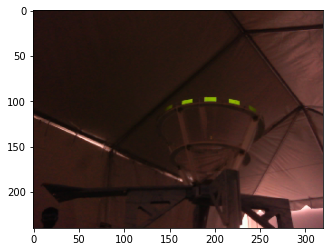

In [5]:
img = cv2.imread(files[0])   # Read the image as BGR
plt.imshow(img)   # Ploting the image using matplotlib

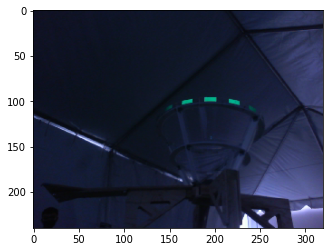

In [6]:
# convert to RGB color convention 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

### RGB components

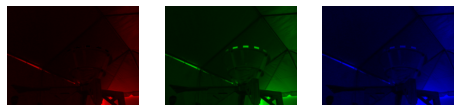

In [7]:
# look at the individual components in RGB space
fix, axs = plt.subplots(ncols=3, nrows=1, figsize=(8,3))
for ix, ax in enumerate(axs):
    temp = np.zeros(img_rgb.shape, dtype='uint8')
    temp[:,:,ix] = img_rgb[:,:,ix]
    ax.imshow(temp)
    ax.set_axis_off()
plt.show()

### HSV components  - note H goes to 180

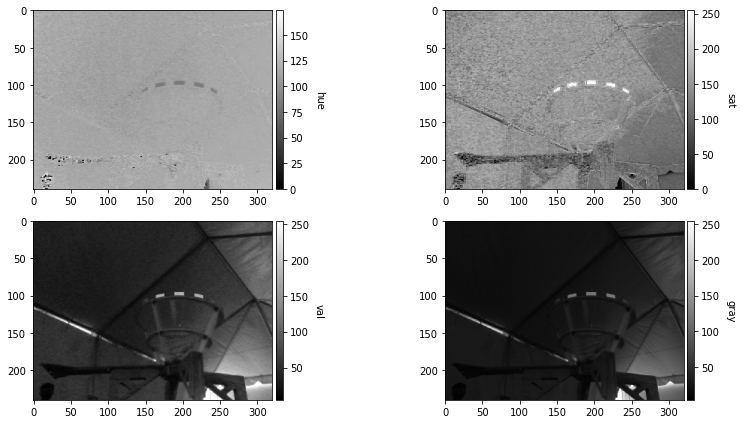

In [8]:
# look at them in HSV space
# look at the individual components in RGB space
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
divider = [None, None, None, None]
cax = [None, None, None, None]
cbar_legend = ['hue', 'sat', 'val', 'gray']
cmap = 'gray'
for ix, ax in (enumerate(axs.flatten()[0:3])):
    temp = np.zeros(img_hsv.shape[0:2], dtype='uint8')
    temp[:,:] = img_hsv[:,:,ix]
    im = ax.imshow(temp, cmap=cmap)
    divider[ix] = make_axes_locatable(ax)
    cax[ix] = divider[ix].append_axes("right", size="3%", pad=0.05)
    cb = plt.colorbar(im, cax=cax[ix])
    cb.ax.set_ylabel(cbar_legend[ix], rotation=270, labelpad=15)
    ax.imshow(temp, cmap=cmap)

ix=3
ax = axs[1,1]
temp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
im = ax.imshow(temp, cmap=cmap)
divider[ix] = make_axes_locatable(ax)
cax[ix] = divider[ix].append_axes("right", size="3%", pad=0.05)
cb = plt.colorbar(im, cax=cax[ix])
cb.ax.set_ylabel(cbar_legend[ix], rotation=270, labelpad=15)
ax.imshow(temp, cmap=cmap)
    
fig.tight_layout()

### start a pipeline

In [9]:
from spartan_overlay import SpartanOverlay

In [10]:
color = 'green'
camera='lifecam'
pipeline = SpartanOverlay(color=color, camera=camera)

#### test all at once

In [11]:
files = glob.glob('**training_images/avr_training/selected_hub/*.png*', recursive=True)
len(files)

12

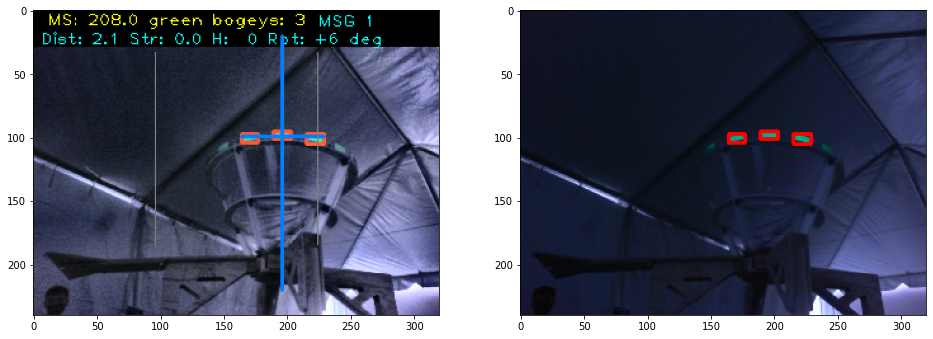

hue:[80, 87], sat:[130, 255], val:[150, 255]


In [12]:
file = files[0]
img_rgb = cv2.imread(file)  # pipeline expecte BGR
pipeline.process(img_rgb)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs[1].imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
axs[0].imshow(cv2.cvtColor(pipeline.image, cv2.COLOR_BGR2RGB))
plt.show()
print(f'hue:{pipeline._hsv_threshold_hue}, sat:{pipeline._hsv_threshold_saturation}, val:{pipeline._hsv_threshold_value}')

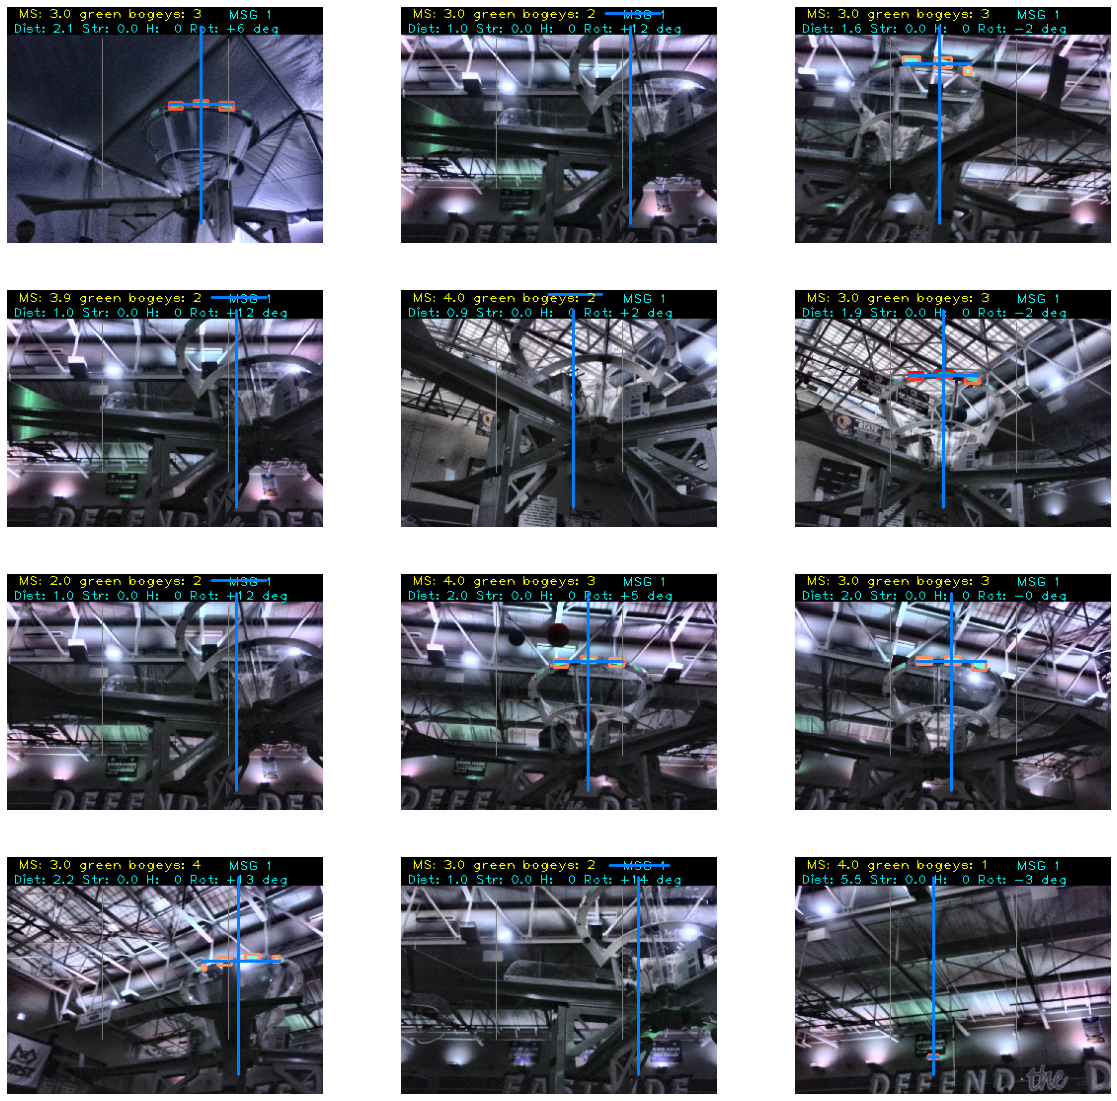

CPU times: total: 1.36 s
Wall time: 1.44 s


In [13]:
%%time
nrows = 4
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))
for ix, row in enumerate(axs):
    for iy, ax in enumerate(row):
        # print((ncols)*ix + iy)
        img = cv2.imread(files[(ncols)*ix + iy])
        pipeline.process(img)
        # label = avr_green_correction(pipeline)
        # if len(label) > 0:
        #     print(f'{(ncols)*ix + iy}: {label}')
        ax.imshow(cv2.cvtColor(pipeline.image, cv2.COLOR_BGR2RGB))
        ax.set_axis_off()
plt.show()

In [14]:
pipeline.bounding_boxes

((135, 200, 10, 4),)

In [15]:
## AVR obnoxious green light
def avr_green_correction(self):
    label = ''
    if self.color == 'green' and len(self.filter_contours_output) > 1:
        max_distance_x = 60
        max_distance_y = 40
        # remove x outlier on the left
        self.bounding_box_sort_contours(method='left-to-right')
        spacing = self.bounding_boxes[1][0] - self.bounding_boxes[0][0] 
        if spacing > max_distance_x:
            label += f'X left limit violated: {spacing}'
            # remove the first contour
            self.filter_contours_output = self.filter_contours_output[1:]

        # remove y outlier on the bottom
        if len(self.filter_contours_output) > 1:
            self.bounding_box_sort_contours(method='bottom-up')
            spacing = self.bounding_boxes[0][1] - self.bounding_boxes[1][1] 
            if spacing > max_distance_y:
                label += f'Y lower limit violated: {spacing}'
                self.filter_contours_output = self.filter_contours_output[1:]

        # possibly remove outlier on right
        if len(self.filter_contours_output) > 1:
            self.bounding_box_sort_contours(method='right-to-left')
            spacing = abs(self.bounding_boxes[0][0] - self.bounding_boxes[1][0])  # abs for safety 
            if spacing > max_distance_x:
                label += f'X right limit violated: {spacing}'
                # remove the first contour
                self.filter_contours_output = self.filter_contours_output[1:]

        # possibly remove outlier on top
        if len(self.filter_contours_output) > 1:
            self.bounding_box_sort_contours(method='top-down')
            spacing = self.bounding_boxes[1][1] - self.bounding_boxes[0][1] 
            if spacing > max_distance_y:
                label += f'Y upper limit violated: {spacing}'
                self.filter_contours_output = self.filter_contours_output[1:]
    return label

In [16]:
pipeline.bounding_box_sort_contours(method='left-to-right')
pipeline.bounding_boxes

((135, 200, 10, 4),)

In [17]:
pipeline.bounding_box_sort_contours(method='right-to-left')
pipeline.bounding_boxes

((135, 200, 10, 4),)

In [18]:
pipeline.bounding_box_sort_contours(method='top-down')
pipeline.bounding_boxes

((135, 200, 10, 4),)

In [19]:
pipeline.bounding_box_sort_contours(method='bottom_up')
pipeline.bounding_boxes

((135, 200, 10, 4),)